In [11]:
import pandas as pd

In [12]:
df= pd.read_csv("../Data/raw/subset_data_model.csv")

In [13]:
df.head()

,sentiment,text,tokens
0,neutral,decide eat aware going take hour beginning end...,"['decide', 'eat', 'aware', 'going', 'take', 'h..."
1,positive,ive taken lot spin class year nothing compare ...,"['ive', 'taken', 'lot', 'spin', 'class', 'year..."
2,neutral,family diner buffet eclectic assortment large ...,"['family', 'diner', 'buffet', 'eclectic', 'ass..."
3,positive,wow yummy different delicious favorite lamb cu...,"['wow', 'yummy', 'different', 'delicious', 'fa..."
4,positive,cute interior owner gave u tour upcoming patio...,"['cute', 'interior', 'owner', 'gave', 'u', 'to..."


In [14]:
df.shape

(50000, 3)

In [15]:
df_reviews=df.tail(6000)

In [16]:
df_reviews.shape

(6000, 3)

In [17]:
# Import required libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [23]:
# Preprocess text data
df_reviews.loc[:, 'processed_text'] = df_reviews['tokens'].apply(
    lambda tokens: ' '.join(eval(tokens)) if isinstance(tokens, str) else ' '.join(tokens)
)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
X_tfidf = tfidf_vectorizer.fit_transform(df_reviews['processed_text'])

# Assuming 'label' column contains target labels
y = df_reviews['sentiment']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [19]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": MultinomialNB()
}

In [20]:
# Train, evaluate, and compare models
results = {}
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    # Classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    # ROC-AUC Score
    if y_pred_prob is not None:
        roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
        print(f"{name} ROC-AUC Score: {roc_auc}")
        results[name] = (roc_auc, y_pred)
    
    


--- Training Logistic Regression ---

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.74      0.76       226
     neutral       0.40      0.47      0.43       145
    positive       0.90      0.88      0.89       829

    accuracy                           0.81      1200
   macro avg       0.69      0.70      0.69      1200
weighted avg       0.82      0.81      0.81      1200

Logistic Regression ROC-AUC Score: 0.876963576276662

--- Training Decision Tree ---

Decision Tree Classification Report:
              precision    recall  f1-score   support

    negative       0.46      0.50      0.48       226
     neutral       0.23      0.30      0.26       145
    positive       0.81      0.75      0.78       829

    accuracy                           0.65      1200
   macro avg       0.50      0.51      0.50      1200
weighted avg       0.67      0.65      0.66      1200

Decision Tree ROC-AUC Score: 0.64

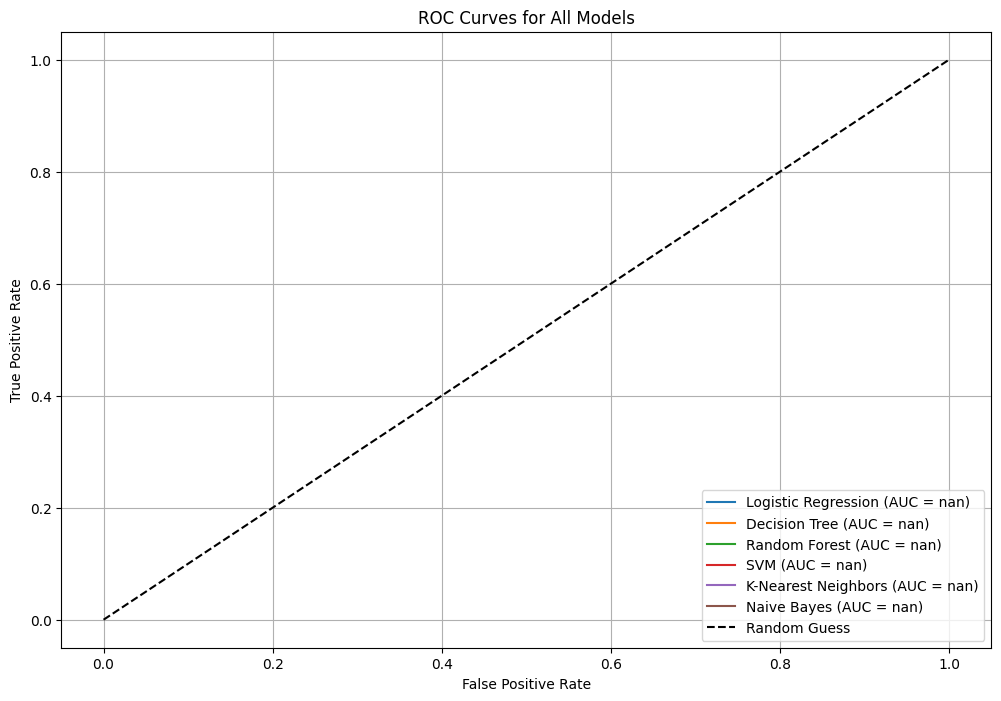

In [45]:
# Plot all ROC curves
plt.figure(figsize=(12, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        # Get predicted probabilities for the positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        # For SVC, use the decision function and normalize it
        y_pred_prob = model.decision_function(X_test)
        y_pred_prob = (y_pred_prob - y_pred_prob.min()) / (y_pred_prob.max() - y_pred_prob.min())
    else:
        print(f"Model {name} does not support probabilities, skipping ROC.")
        continue

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()
